# Flexural specimens

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 16})

def process_specimens(specimen_count, file_path_template, c1, c2, data_row_start, data_rows_end, data_linear_start, data_linear_end, b, h, L, corrected , flexion, compression, shear , specimen_number,DIC_short):
    """
    Processes flexural specimen data, performs calculations, and generates plots.

    Parameters:
        specimen_count (int): Number of specimens to process.
        file_path_template (str): Template for file paths with placeholders for specimen numbers.
        c1 (int): Column index for extension data.
        c2 (int): Column index for load data.
        data_row_start (dict): Starting row indices for each specimen.
        data_rows_end (dict): Ending row indices for each specimen.
        data_linear_start (dict): Starting row indices for linear regression.
        data_linear_end (dict): Ending row indices for linear regression.
        b (dict): Widths of specimens.
        h (dict): Heights of specimens.
        L (float): Length of the specimens.

    Returns:
        None
    """
    # Initialize data structures
    data = {
        "extension": [],
        "load": [],
        "strain": [],
        "stress": [],
        "slope": [],
        "intercept": [],
        "stderr": [],
        "uncertainty": [],
        "stress_max": [],
        "interlaminar": [],
    }
    
# = range(1, specimen_count + 1))
    # Loop through specimens and process data
    # for k in np.arange(1, specimen_count + 1):
    for k in specimen_number:
        
        # Read the CSV file
        df = pd.read_csv(file_path_template.format(k), skiprows=10)

        # Slice the DataFrame to get the required columns and rows
        extension = df.iloc[data_row_start[k]:data_rows_end[k], c1]
        load = df.iloc[data_row_start[k]:data_rows_end[k], c2]

        # Stress and strain calculations
        if flexion:
            # For flexural specimens
            df['stress'] = 3 * load * L / (2 * b[k] * h[k] ** 2)
            df['strain'] = 6 * extension * h[k] / L ** 2
        elif compression:
            # For tensile specimens
            df['stress'] = load / (b[k] * h[k])
            df['strain'] = extension / L

        elif shear:
            df['stress'] = 3 * load * L / (2 * b[k] * h[k] ** 2)
            df['strain'] = extension 
            interlaminar_shear_strength = 0.75 * np.max(load) / (b[k] * h[k])
            data["interlaminar"].append(interlaminar_shear_strength)
            #from slope_list lets calculate mean , standard deviation and variance
            slope_mean = np.mean( data["interlaminar"])
            slope_std = np.std( data["interlaminar"])
            #coefficent of variation
            slope_var = 100* slope_std / slope_mean

        elif DIC_short:
            df_2 = pd.read_csv(file_path_template.format(k), skiprows=10)
            extension_2 = df.iloc[data_row_start[k]:data_rows_end[k], c1]

            #stress calculation
            df['stress'] = - 0.75 * load / ( b[k] * h[k] )
            #strain calculation
            # df['strain'] = (2) * (np.abs(extension)
            df['strain'] = (np.abs(extension) - np.abs(extension_2))


    
        if corrected:
            df['strain'] = 6 * ( extension + 1.085876285) * h[k] / L ** 2
        # Store data
        data["extension"].append(extension)
        data["load"].append(load)
        data["strain"].append(df['strain'])
        data["stress"].append(df['stress'])

        # Perform linear regression on the linear part of strain and stress
        df_strain = df['strain'].iloc[data_linear_start[k]:data_linear_end[k]]
        df_stress = df['stress'].iloc[data_linear_start[k]:data_linear_end[k]]
        slope, intercept, _, _, stderr = stats.linregress(df_strain, df_stress)

        # Store regression results
        data["slope"].append(round(slope, 1))
        data["intercept"].append(round(intercept, 1))
        data["stderr"].append(round(stderr, 1))

        # uncertainty of multiplication of calculation of area with variables b and h
        uncertainty_a = b[k] * h[k] * np.sqrt((0.01/b[k])**2 + (0.01/h[k])**2)
        # we have uncertainty of area now lets calulate the uncertainty of stress
        uncertainty_s = np.max(load) * np.sqrt((uncertainty_a/(b[k] * h[k]))**2 + (0.01/np.max(load))**2)   

        data["uncertainty"].append(uncertainty_s)
        data["stress_max"].append(np.max(df['stress']))


    if shear:
        print(f'Mean Interl: {slope_mean}')
        print(f'Standard Deviation Interl: {slope_std}')
        print(f'Coeff Variance Interl: {slope_var}')
        print(f'Uncertainty Interl: {uncertainty_s}')
        # Plot Extension vs Load
        plt.figure(figsize=(10, 6))
        for k in range(len(data["extension"])):
            plt.plot(data["extension"][k], data["load"][k], label=f'Specimen {k + 1}', linewidth=1)
        # plt.title('Extension vs Load')
        plt.xlabel('Extension (mm)')
        plt.ylabel('Load (N)')
        plt.grid()
        plt.legend()
        plt.savefig('Extension_vs_Load.png')
        plt.show()

    elif flexion or compression:
        # Plot Strain vs Stress
        plt.figure(figsize=(10, 6))
        for k in range(len(data["strain"])):
            plt.plot(data["strain"][k], data["stress"][k], label=f'Specimen {k + 1}', linewidth=1)
        # plt.title('Strain vs Stress')
        plt.xlabel('Strain')
        plt.ylabel('Stress (MPa)')
        plt.grid()
        plt.legend()
        plt.savefig('Strain_vs_Stress.png')
        plt.show()

        # Print statistics
        slope_mean = np.mean(data["slope"])/1000
        slope_std = np.std(data["slope"])/1000
        slope_cv = (slope_std / slope_mean) * 100

        if flexion:
            print(f'Mean of error GPa: {np.mean(data["stderr"])/1000}')
            print(f'Mean of flexural modulus GPa: {slope_mean}')
            print(f'Standard deviation of slope GPa: {slope_std}')
            print(f'Coefficient of variation of slope: {slope_cv}%')
 
            # Plot flexural modulus for each specimen
            plt.figure(figsize=(8, 6))
            plt.bar(np.arange(1, specimen_count + 1), np.array(data["slope"]) / 1000, yerr=np.array(data["stderr"]) / 1000, capsize=5, zorder=3)
            plt.xlabel('Specimen')
            plt.ylabel('Flexural modulus (GPa)')
            plt.grid(axis='y', zorder=0)
            plt.savefig('Flexural_Modulus_GPa.png')
            plt.show()

            slope_mean = np.mean(data["stress_max"])
            slope_std = np.std(data["stress_max"])
            slope_var = np.var(data["stress_max"])

            #calculation of sample coefficient of variation
            slope_cv = (slope_std/slope_mean) * 100

            print(f'Mean of uncertainty flex strength: {np.mean(data["uncertainty"])}')
            print(f'Mean of slope  flex strength: {slope_mean}')
            print(f'Standard deviation of slope  flex strength: {slope_std}')
            print(f'Coefficient of variation of slope  flex strength: {slope_cv}%')

            # Plot stress max for each specimen
            plt.figure(figsize=(8, 6))
            plt.bar(np.arange(1, specimen_count + 1), np.array(data["stress_max"]), yerr=np.array(data["uncertainty"]), capsize=5, zorder=3)
            plt.xlabel('Specimen')
            plt.ylabel('Stress max (MPa)')
            plt.grid(axis='y', zorder=0)
            plt.savefig('Stress_max.png')
            plt.show()
        
        elif compression:
            print(f'Mean of error GPa: {np.mean(data["stderr"])/1000}')
            print(f'Mean of compression modulus GPa: {slope_mean}')
            print(f'Standard deviation of slope GPa: {slope_std}')
            print(f'Coefficient of variation of slope: {slope_cv}%')

            # Plot flexural modulus for each specimen
            plt.figure(figsize=(8, 6))
            plt.bar(np.arange(1, specimen_count + 1), np.array(data["slope"]) / 1000, yerr=np.array(data["stderr"]) / 1000, capsize=5, zorder=3)
            plt.xlabel('Specimen')
            plt.ylabel('Compression modulus (GPa)')
            plt.grid(axis='y', zorder=0)
            plt.savefig('Compression_Modulus_GPa.png')
            plt.show()

            slope_mean = np.mean(data["stress_max"])
            slope_std = np.std(data["stress_max"])
            slope_var = np.var(data["stress_max"])

            #calculation of sample coefficient of variation
            slope_cv = (slope_std/slope_mean) * 100

            print(f'Mean of uncertainty compress strength: {np.mean(data["uncertainty"])}')
            print(f'Mean of slope  compress strength: {slope_mean}')
            print(f'Standard deviation of slope  compress strength: {slope_std}')
            print(f'Coefficient of variation of slope  compress strength: {slope_cv}%')

            # Plot stress max for each specimen
            plt.figure(figsize=(8, 6))
            plt.bar(np.arange(1, specimen_count + 1), np.array(data["stress_max"]), yerr=np.array(data["uncertainty"]), capsize=5, zorder=3)
            plt.xlabel('Specimen')
            plt.ylabel('Stress max (MPa)')
            plt.grid(axis='y', zorder=0)
            plt.savefig('Stress_max.png')
            plt.show()
    elif DIC_short:
        # Store data
        slope_mean = np.mean(data["slope"])
        slope_std = np.std(data["slope"])
        slope_cv = (slope_std / slope_mean) * 100

        # Print 
        print(f'Mean of error GPa Interlaminar: {np.mean(data["stderr"])}')
        print(f'Mean of flexural modulus MPa: {slope_mean}')
        print(f'Standard deviation of slope MPa: {slope_std}')
        print(f'Coefficient of variation of slope: {slope_cv}%')

        for k in range(len(data["strain"])):
            plt.scatter(df["strain"][k], data["stress"][k], label=f'Specimen {k + 1}',s = 1)
            # plt.scatter(df['strain'] , df['stress'], label=f'Specimen {k}',s=2)
            # plt.plot(data["strain"][k], data["stress"][k], label=f'Specimen {k + 1}', linewidth=1)
 
        plt.xlabel('Strain')
        plt.ylabel('Stress (MPa)')
        plt.grid()
        plt.legend()

    return data['stderr']


def select_best_specimens(stderr_list, specimen_count=6):
    """
    Selects the specimens with the least standard deviation.

    Parameters:
        stderr_list (list): List of standard errors for all specimens.
        specimen_count (int): Number of specimens to select (default is 5).

    Returns:
        list: Indices of the selected specimens (1-based indexing).
    """
    # Pair each specimen index with its standard deviation
    specimen_stderr = list(enumerate(stderr_list, start=1))  # 1-based indexing

    # Sort specimens by standard deviation (ascending order)
    sorted_specimens = sorted(specimen_stderr, key=lambda x: x[1])

    # Select the top specimens with the least standard deviation
    best_specimens = sorted_specimens[:specimen_count]

    # Extract and return the indices of the selected specimens
    return [specimen[0] for specimen in best_specimens]

# Example usage
# stderr_list = [0.12, 0.08, 0.15, 0.05, 0.09, 0.11, 0.07, 0.10, 0.13, 0.06, 0.14, 0.04, 0.08, 0.09, 0.07, 0.05]
# stderr_list = L[:]
# best_specimens = select_best_specimens(stderr_list)
# print(f"Best specimens (indices): {best_specimens}")


## 3-axis specimens

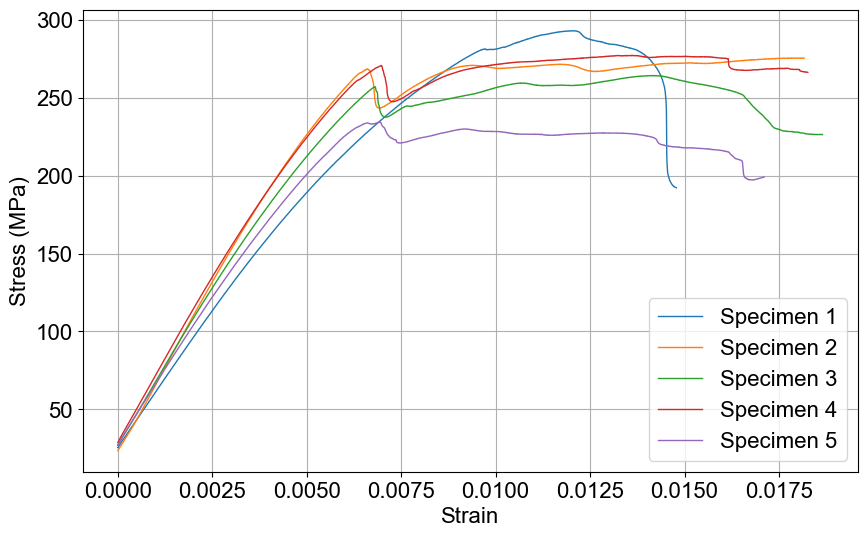

Mean of error GPa: 0.02924
Mean of flexural modulus GPa: 39.64004
Standard deviation of slope GPa: 3.3664411265311025
Coefficient of variation of slope: 8.492527067407355%


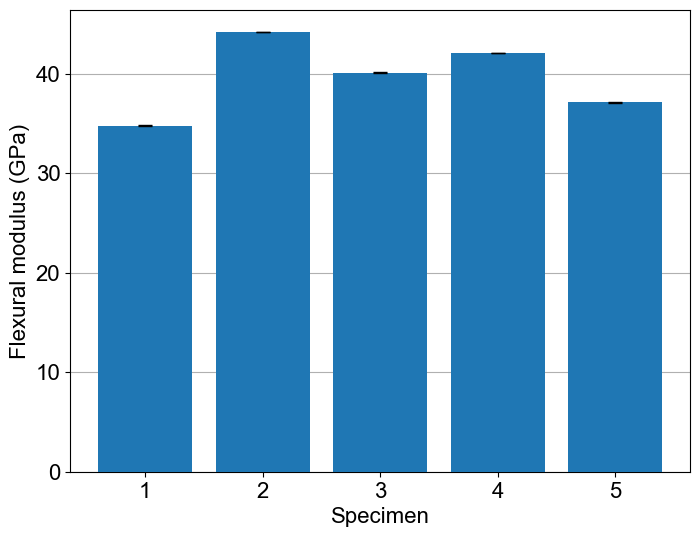

Mean of uncertainty flex strength: 1.2838744008849157
Mean of slope  flex strength: 268.78005722779005
Standard deviation of slope  flex strength: 19.541139669887997
Coefficient of variation of slope  flex strength: 7.270308620154417%


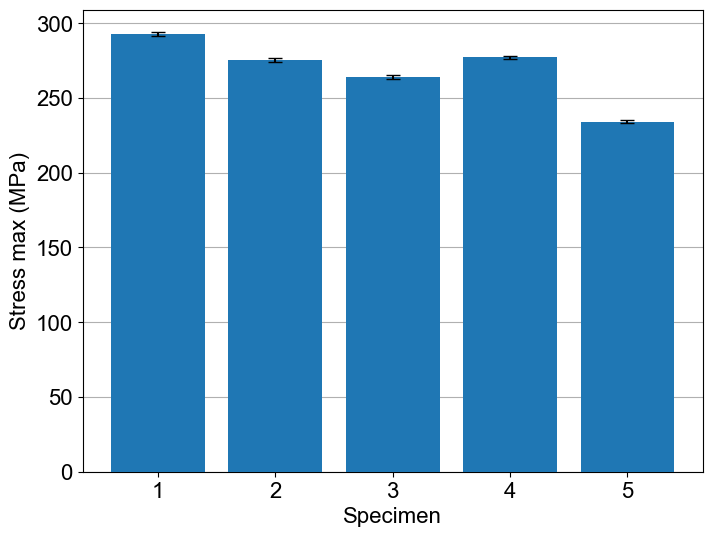

[19.0, 24.4, 38.2, 31.0, 33.6]

In [7]:
specimen_count = 5
process_specimens(
    corrected=False,
    flexion=True,
    compression=False,
    shear=False,
    specimen_count=5,
    file_path_template='flexion/3_axis/Specimen_RawData_{}.csv',
    c1=1,
    c2=2,
    data_row_start={1: 0, 2: 0, 3: 0, 4: 0, 5: 0},
    data_rows_end={1: 2500, 2: 2500, 3: 2500, 4: 2500, 5: 2500},
    data_linear_start={1: 110, 2: 110, 3: 110, 4: 110, 5: 110},
    data_linear_end={1: 360, 2: 360, 3: 360, 4: 360, 5: 360},
    b={1: 13.06, 2: 12.95, 3: 12.87, 4: 12.84, 5: 12.91},
    h={1: 3.83, 2: 3.77, 3: 3.87, 4: 3.79, 5: 3.88},
    L=72,
    specimen_number=range(1, specimen_count + 1),
)

## 5 axis specimens

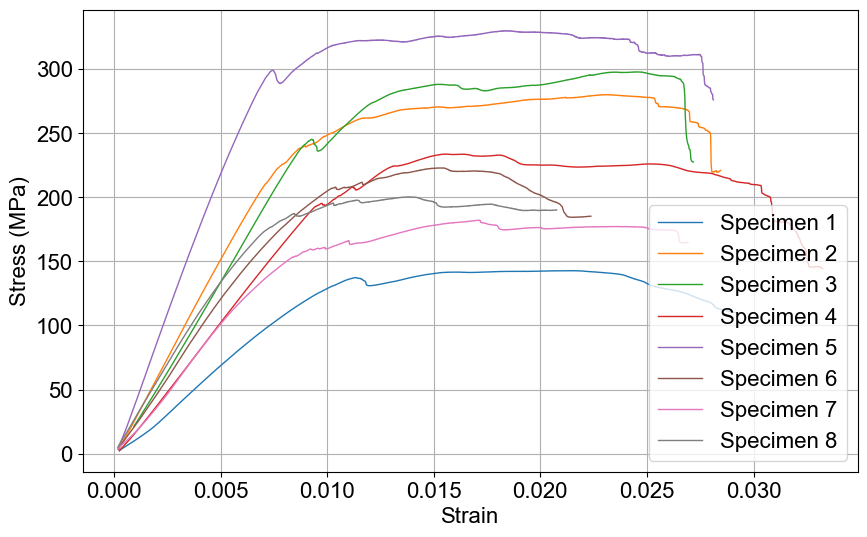

Mean of error GPa: 0.018662500000000002
Mean of flexural modulus GPa: 26.940887500000002
Standard deviation of slope GPa: 8.83925183081655
Coefficient of variation of slope: 32.809801944410886%


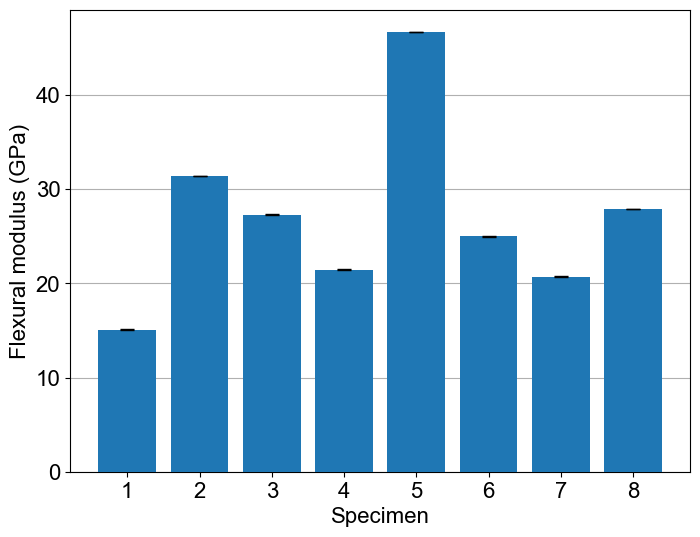

Mean of uncertainty flex strength: 1.5080112615199626
Mean of slope  flex strength: 236.23648160212105
Standard deviation of slope  flex strength: 58.7939323722002
Coefficient of variation of slope  flex strength: 24.887744675787758%


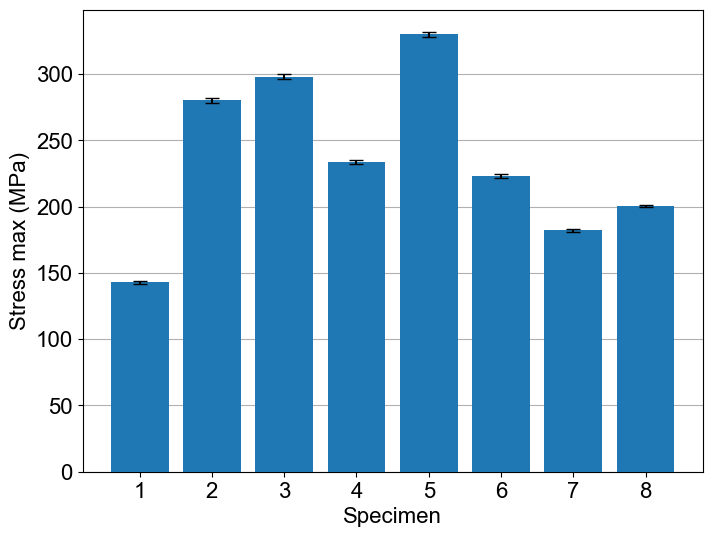

[28.9, 3.7, 11.7, 7.8, 16.5, 28.4, 45.6, 6.7]

In [9]:
specimen_count=8
process_specimens(
    corrected=True,
    flexion=True,
    compression=False,
    shear=False,
    specimen_count=8,
    file_path_template='flexion/5_axis/Specimen_RawData_{}.csv',
    c1=4,
    c2=2,
    data_row_start={1: 2, 2: 2, 3: 85, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2},
    data_rows_end={1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000, 6: 4000, 7: 4000, 8: 4000},
    data_linear_start={1: 110, 2: 110, 3: 110, 4: 110, 5: 110, 6: 110, 7: 110, 8: 110},
    data_linear_end={1: 360, 2: 360, 3: 360, 4: 360, 5: 360, 6: 360, 7: 360, 8: 360},
    b={1: 14.23, 2: 14.37, 3: 14.93, 4: 13.48, 5: 14.06, 6: 13.79, 7: 14.28, 8: 13.45},
    h={1: 5.49, 2: 4.67, 3: 4.77, 4: 5.42, 5: 4.13, 6: 4.6, 7: 4.32, 8: 4.01},
    L=72,
    specimen_number=range(1, specimen_count + 1),
)

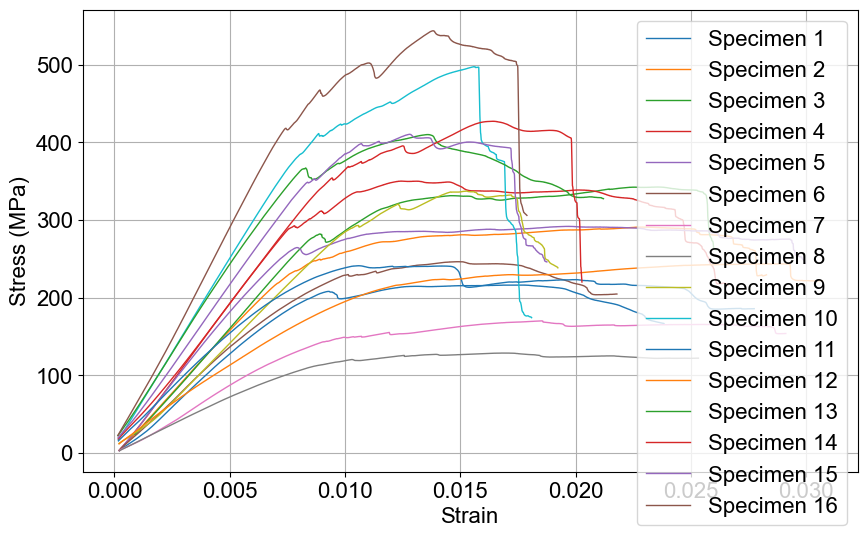

Mean of error GPa: 0.029331249999999996
Mean of flexural modulus GPa: 33.74809375
Standard deviation of slope GPa: 10.529670982957441
Coefficient of variation of slope: 31.200787401384535%


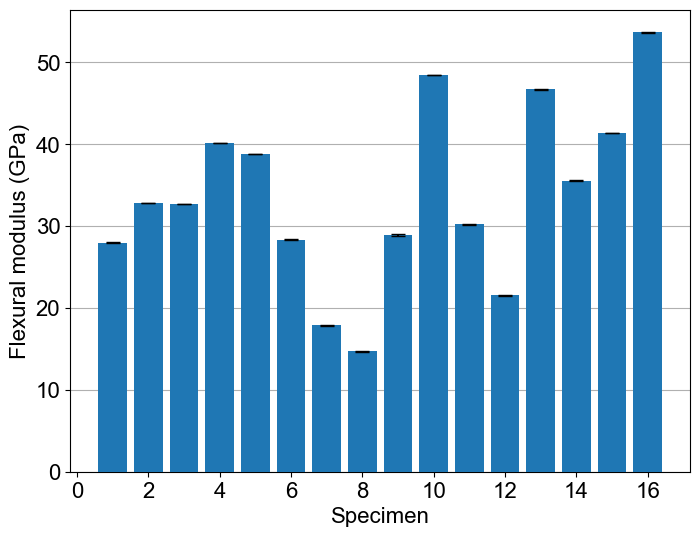

Mean of uncertainty flex strength: 1.9991016890756195
Mean of slope  flex strength: 321.8310944031541
Standard deviation of slope  flex strength: 111.73635904789029
Coefficient of variation of slope  flex strength: 34.71894449947693%


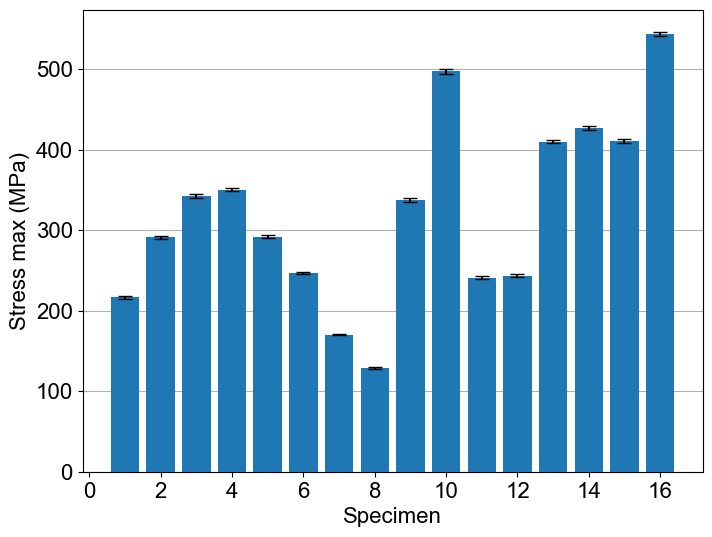

[53.6, 3.8, 14.0, 14.6, 13.7, 32.2, 39.5, 3.6, 81.1, 11.3, 11.8, 33.5, 25.7, 49.4, 27.3, 54.2]


In [12]:
specimen_count=16

L = process_specimens(
    corrected=True,
    flexion=True,
    compression=False,
    shear=False,
    specimen_count=16,
    file_path_template='flexion/5_axis/Specimen_RawData_{}.csv',
    c1=4,
    c2=2,
    data_row_start={
        1: 2, 2: 2, 3: 85, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2,
        9: 2, 10: 2, 11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2
    },
    data_rows_end={
        1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000, 6: 4000, 7: 4000, 8: 4000,
        9: 4000, 10: 4000, 11: 4000, 12: 4000, 13: 4000, 14: 4000, 15: 4000, 16: 4000
    },
    data_linear_start={
        1: 110, 2: 110, 3: 110, 4: 110, 5: 110, 6: 110, 7: 110, 8: 110,
        9: 110, 10: 110, 11: 110, 12: 110, 13: 110, 14: 110, 15: 110, 16: 110
    },
    data_linear_end={
        1: 360, 2: 360, 3: 360, 4: 360, 5: 360, 6: 360, 7: 360, 8: 360,
        9: 360, 10: 360, 11: 360, 12: 360, 13: 360, 14: 360, 15: 360, 16: 360
    },
    b={
        1: 14.03, 2: 14.01, 3: 14.08, 4: 14.03, 5: 14.00, 6: 13.15, 7: 13.07, 8: 14.06,
        9: 14.23, 10: 14.37, 11: 14.93, 12: 13.48, 13: 14.06, 14: 13.79, 15: 14.28, 16: 13.45
    },
    h={
        1: 4.49, 2: 4.64, 3: 4.58, 4: 4.34, 5: 4.40, 6: 4.48, 7: 4.67, 8: 4.89,
        9: 5.49, 10: 4.67, 11: 4.77, 12: 5.42, 13: 4.13, 14: 4.6, 15: 4.32, 16: 4.01
    },
    L=72,
    specimen_number=range(1, specimen_count + 1),
)
print(L[:])

In [13]:
stderr_list = L[:]
best_specimens = select_best_specimens(stderr_list)
print(f"Best specimens (indices): {best_specimens}")

Best specimens (indices): [8, 2, 10, 11, 5, 3]


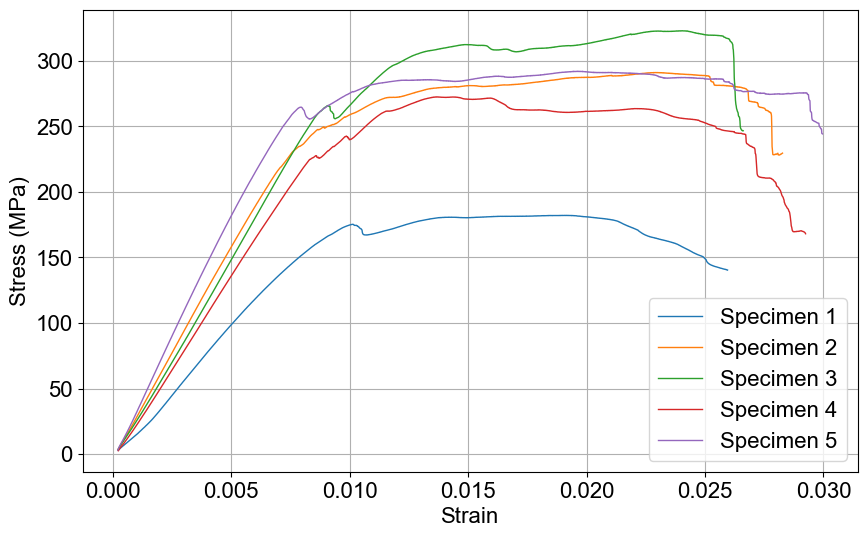

Mean of error GPa: 0.016419999999999997
Mean of flexural modulus GPa: 30.3903
Standard deviation of slope GPa: 5.613062976664345
Coefficient of variation of slope: 18.469916311008266%


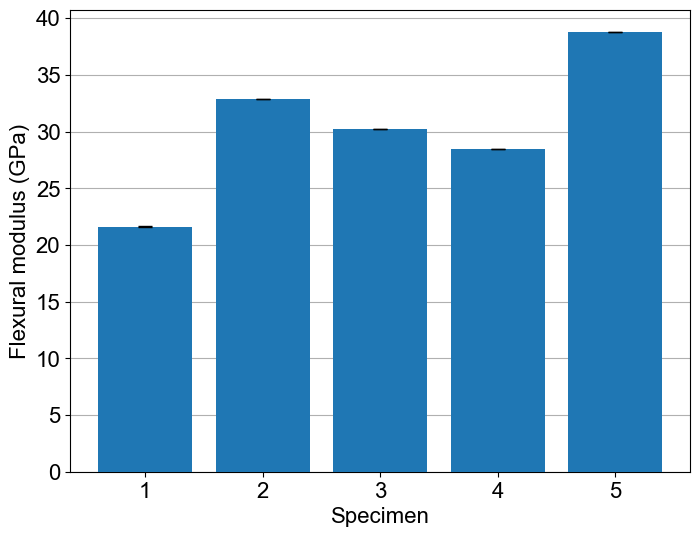

Mean of uncertainty flex strength: 1.7629219530357065
Mean of slope  flex strength: 272.1033766157087
Standard deviation of slope  flex strength: 47.81328186349999
Coefficient of variation of slope  flex strength: 17.571734117444134%


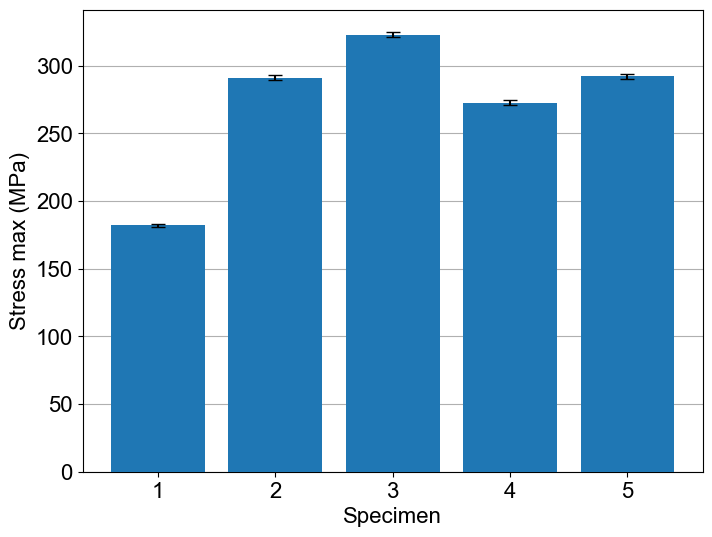

[41.4, 3.8, 12.9, 10.3, 13.7]

In [15]:
# Indices of the best specimens
best_specimens = [8, 2, 10, 11, 5]

data_row_start={
    1: 2, 2: 2, 3: 85, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2,
    9: 2, 10: 2, 11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2
}
data_rows_end={
    1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000, 6: 4000, 7: 4000, 8: 4000,
    9: 4000, 10: 4000, 11: 4000, 12: 4000, 13: 4000, 14: 4000, 15: 4000, 16: 4000
}
data_linear_start={
    1: 110, 2: 110, 3: 110, 4: 110, 5: 110, 6: 110, 7: 110, 8: 110,
    9: 110, 10: 110, 11: 110, 12: 110, 13: 110, 14: 110, 15: 110, 16: 110
}
data_linear_end={
    1: 360, 2: 360, 3: 360, 4: 360, 5: 360, 6: 360, 7: 360, 8: 360,
    9: 360, 10: 360, 11: 360, 12: 360, 13: 360, 14: 360, 15: 360, 16: 360
}
b={
    1: 14.03, 2: 14.01, 3: 14.08, 4: 14.03, 5: 14.00, 6: 13.15, 7: 13.07, 8: 14.06,
    9: 14.23, 10: 14.37, 11: 14.93, 12: 13.48, 13: 14.06, 14: 13.79, 15: 14.28, 16: 13.45
}
h={
    1: 4.49, 2: 4.64, 3: 4.58, 4: 4.34, 5: 4.40, 6: 4.48, 7: 4.67, 8: 4.89,
    9: 5.49, 10: 4.67, 11: 4.77, 12: 5.42, 13: 4.13, 14: 4.6, 15: 4.32, 16: 4.01
}

specimen_count = 5
process_specimens(
    corrected=True,
    flexion=True,
    compression=False,
    shear=False,
    specimen_count=5,
    file_path_template='flexion/5_axis/Specimen_RawData_{}.csv',
    c1=4,
    c2=2,
    data_row_start={1: data_row_start[8], 2: data_row_start[2], 3: data_row_start[10], 4: data_row_start[11], 5: data_row_start[5]},
    data_rows_end={1: data_rows_end[8], 2: data_rows_end[2], 3: data_rows_end[10], 4: data_rows_end[11], 5: data_rows_end[5]},
    data_linear_start={1: data_linear_start[8], 2: data_linear_start[2], 3: data_linear_start[10], 4: data_linear_start[11], 5: data_linear_start[5]},
    data_linear_end={1: data_linear_end[8], 2: data_linear_end[2], 3: data_linear_end[10], 4: data_linear_end[11], 5: data_linear_end[5]},
    b={1 : b[8], 2 : b[2], 3 : b[10], 4 : b[11], 5 : b[5]},
    h={1: h[8], 2: h[2], 3: h[10], 4: h[11], 5: h[5]},
    L=72,
    specimen_number=range(1, specimen_count + 1)
)


# Compression specimens

### 3 axis

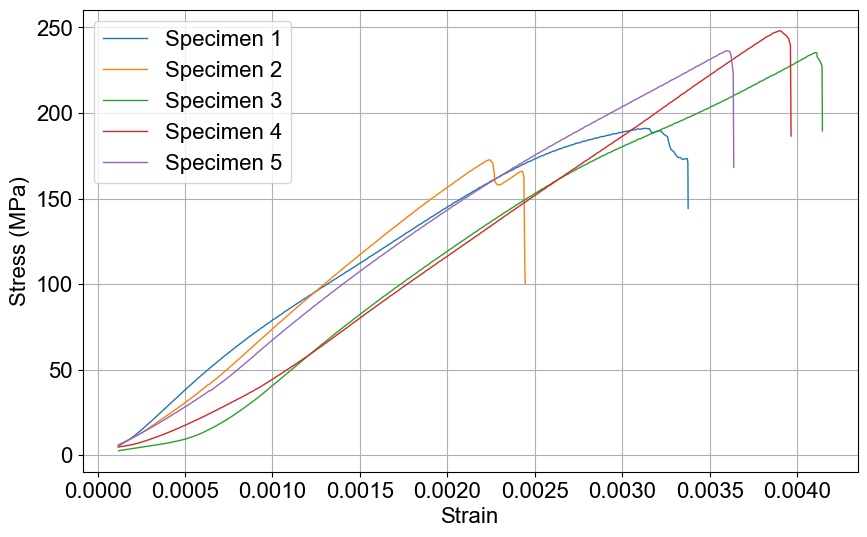

Mean of error GPa: 0.8595600000000001
Mean of compression modulus GPa: 62.76671999999999
Standard deviation of slope GPa: 4.153828429966747
Coefficient of variation of slope: 6.6178835375924505%


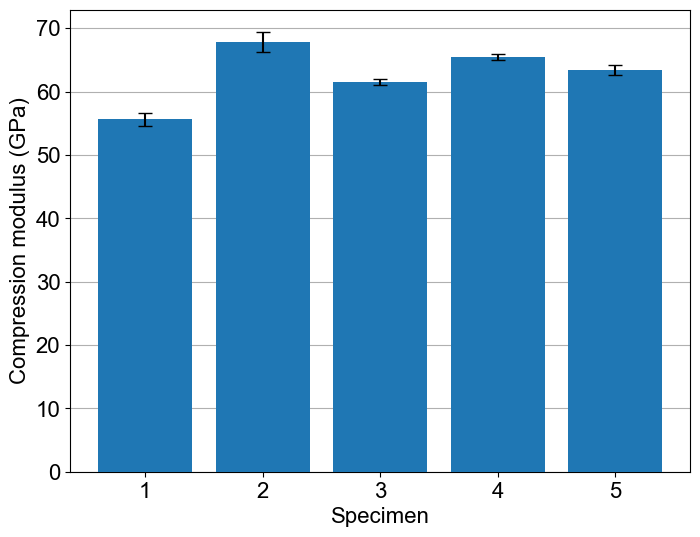

Mean of uncertainty compress strength: 28.863882659859847
Mean of slope  compress strength: 216.6889002865094
Standard deviation of slope  compress strength: 29.373165728327752
Coefficient of variation of slope  compress strength: 13.555454704643429%


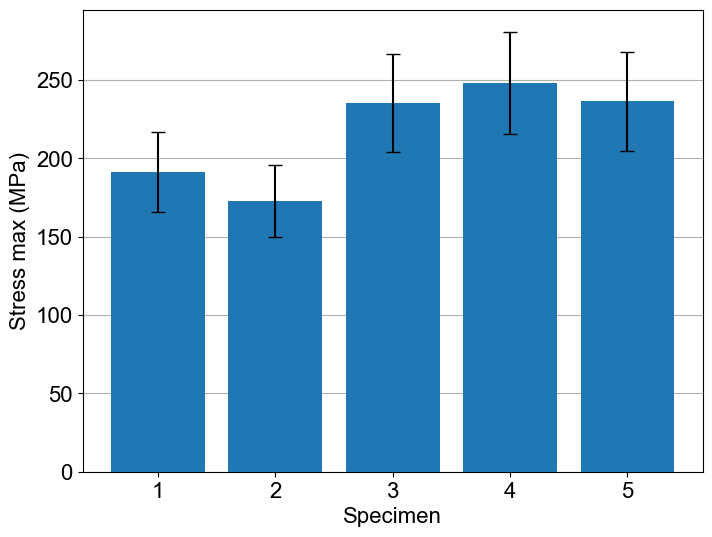

[977.2, 1621.8, 477.6, 466.3, 754.9]

In [16]:
specimen_count = 5
process_specimens(
    corrected=False,
    flexion=False,
    compression=True,
    shear=False,
    specimen_count=5,
    file_path_template='compression/3_axis/Specimen_RawData_{}.csv',
    c1=1,
    c2=2,
    data_rows_end = {1: 260, 2: 200, 3: 320, 4: 310, 5: 290},
    data_row_start = {1: 1, 2: 1, 3: 1, 4: 1, 5: 1},
    data_linear_start={1: 1, 2: 1, 3: 1, 4: 1, 5: 1},
    data_linear_end={1: 260, 2: 200, 3: 320, 4: 310, 5: 290},
    b = {1: 12.74, 2: 12.91, 3: 12.77, 4: 12.59, 5: 12.81},
    h = {1: 4.04, 2: 3.61, 3: 3.83, 4: 3.86, 5: 3.83},
    L=165,
    specimen_number=range(1, specimen_count + 1)
)

### 5 axis

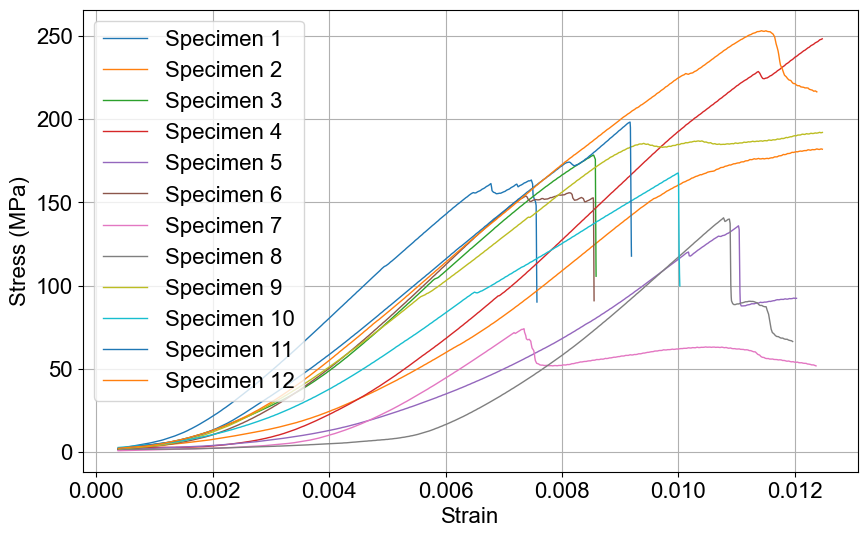

Mean of error GPa: 0.22907499999999997
Mean of compression modulus GPa: 18.656624999999995
Standard deviation of slope GPa: 5.510756655869348
Coefficient of variation of slope: 29.537800410681726%


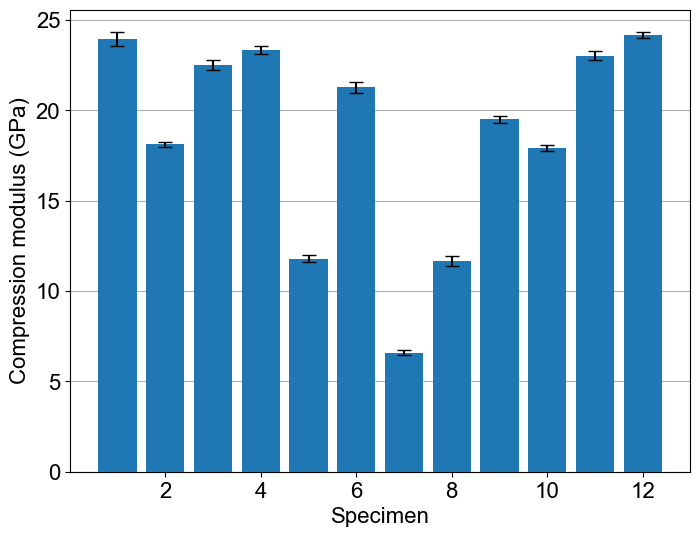

Mean of uncertainty compress strength: 29.84764607875213
Mean of slope  compress strength: 174.18050885014313
Standard deviation of slope  compress strength: 46.36772740219186
Coefficient of variation of slope  compress strength: 26.620502895696852%


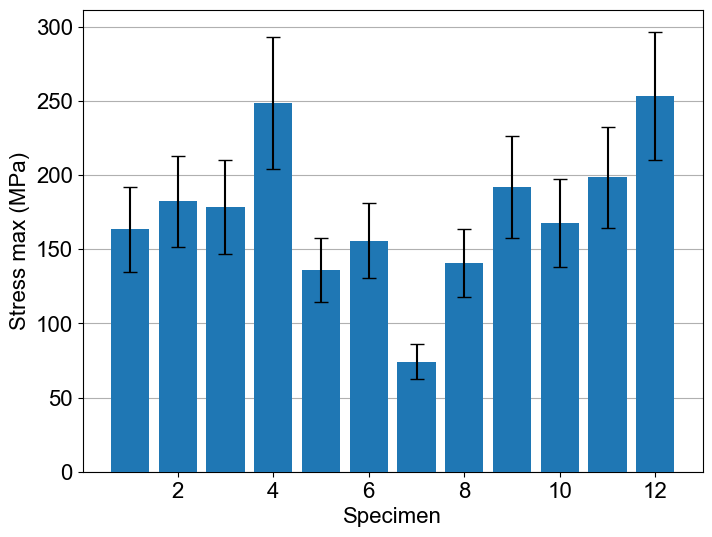

In [17]:
specimen_count = 12
C = process_specimens(
    corrected=False,
    flexion=False,
    compression=True,
    shear=False,
    specimen_count=12,
    file_path_template='compression/5_axis/Specimen_RawData_{}.csv',
    c1=1,
    c2=2,
    data_rows_end = {
        1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500, 7: 500, 8: 500,
        9: 500, 10: 500, 11: 500, 12: 500
    },

    data_row_start = {
        1: 15, 2: 15, 3: 15, 4: 15, 5: 15, 6: 15, 7: 15, 8: 15,
        9: 15, 10: 15, 11: 15, 12: 15
    },

    data_linear_start = {
        1: 15, 2: 15, 3: 15, 4: 15, 5: 15, 6: 15, 7: 15, 8: 15,
        9: 15, 10: 15, 11: 15, 12: 15
    },

    data_linear_end = {
        1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500, 7: 500, 8: 500,
        9: 500, 10: 500, 11: 500, 12: 500
    },
    # Area of the specimen in a dictionary
    b = {
        1: 17.18,  # b_1_A
        2: 16.64,  # b_2_A
        3: 17.3,   # b_3_A
        4: 17.6,   # b_4_A
        5: 15.69,  # b_1_B
        6: 15.64,  # b_2_B
        7: 15.34,  # b_3_B
        8: 15.72,  # b_4_B
        9: 17.6,   # b_1_C
        10: 17.25, # b_2_C
        11: 16.89, # b_3_C
        12: 16.75  # b_4_C
    },

    h = {
        1: 3.43,  # h_1_A
        2: 3.21,  # h_2_A
        3: 3.41,  # h_3_A
        4: 3.00,  # h_4_A
        5: 3.55,  # h_1_B
        6: 3.86,  # h_2_B
        7: 4.07,  # h_3_B
        8: 3.60,  # h_4_B
        9: 3.37,  # h_1_C
        10: 3.55, # h_2_C
        11: 3.37, # h_3_C
        12: 3.54  # h_4_C
    },
    L=80,
    specimen_number=range(1, specimen_count + 1)
)

In [18]:
stderr_list = C[:]
best_specimens = select_best_specimens(stderr_list)
print(f"Best specimens (indices): {best_specimens}")

Best specimens (indices): [7, 2, 12, 9, 10, 5]


15


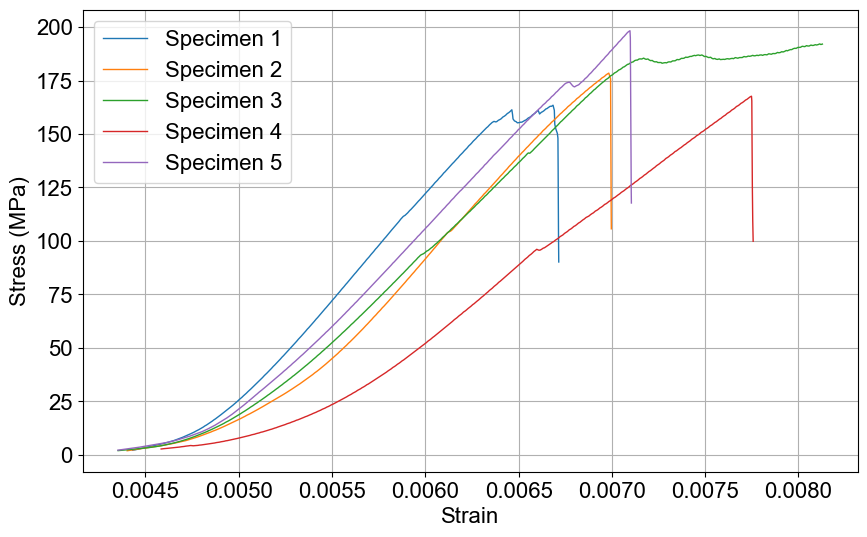

Mean of error GPa: 0.8058799999999999
Mean of compression modulus GPa: 67.4966
Standard deviation of slope GPa: 7.869645118555217
Coefficient of variation of slope: 11.659320793277317%


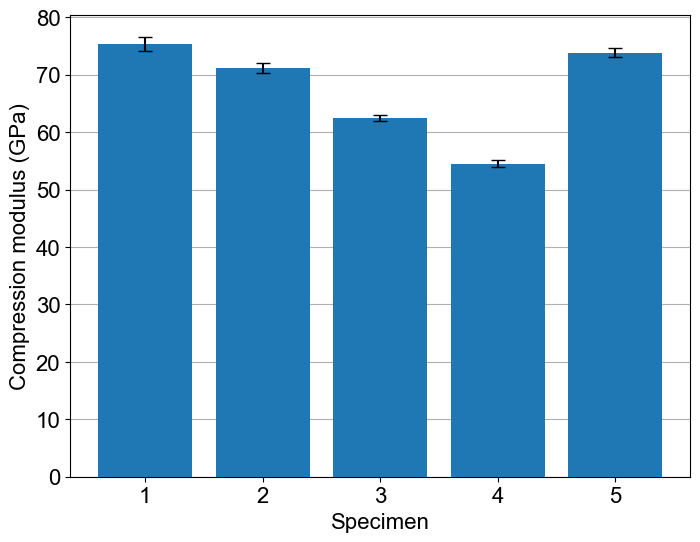

Mean of uncertainty compress strength: 31.640696420194352
Mean of slope  compress strength: 179.9900476244545
Standard deviation of slope  compress strength: 13.485576050120756
Coefficient of variation of slope  compress strength: 7.492400956667409%


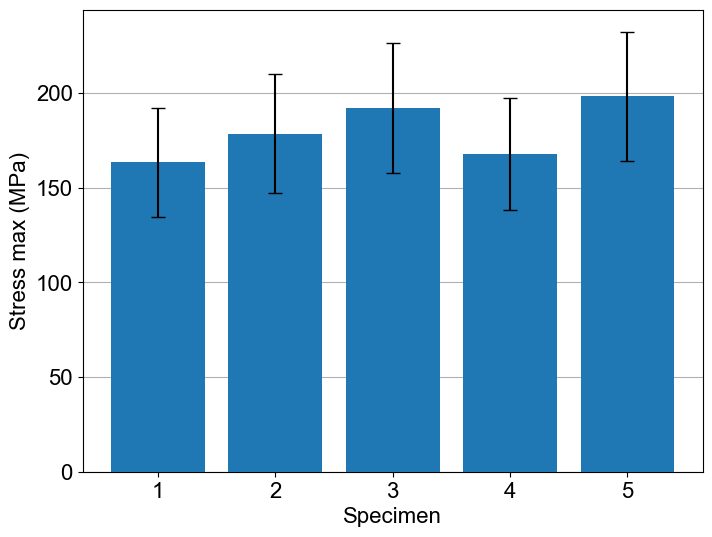

[1236.2, 883.7, 562.1, 552.6, 794.8]

In [19]:
data_rows_end = {
    1: 500, 2: 800, 3: 500, 4: 800, 5: 800, 6: 500, 7: 500, 8: 500,
    9: 500, 10: 500, 11: 500, 12: 500
}

data_row_start = {
    1: 15, 2: 15, 3: 15, 4: 15, 5: 15, 6: 15, 7: 15, 8: 15,
    9: 15, 10: 15, 11: 15, 12: 15
}

data_linear_start = {
    1: 15, 2: 15, 3: 15, 4: 15, 5: 15, 6: 15, 7: 15, 8: 15,
    9: 15, 10: 15, 11: 15, 12: 15
}

data_linear_end = {
    1: 500, 2: 800, 3: 500, 4: 800, 5: 800, 6: 500, 7: 500, 8: 500,
    9: 500, 10: 500, 11: 500, 12: 500
}

print(data_row_start[1])#, data_rows_end[8], data_linear_start[8], data_linear_end[8], b[8], h[8])


# Area of the specimen in a dictionary
b = {
    1: 17.18,  # b_1_A
    2: 16.64,  # b_2_A
    3: 17.3,   # b_3_A
    4: 17.6,   # b_4_A
    5: 15.69,  # b_1_B
    6: 15.64,  # b_2_B
    7: 15.34,  # b_3_B
    8: 15.72,  # b_4_B
    9: 17.6,   # b_1_C
    10: 17.25, # b_2_C
    11: 16.89, # b_3_C
    12: 16.75  # b_4_C
}

h = {
    1: 3.43,  # h_1_A
    2: 3.21,  # h_2_A
    3: 3.41,  # h_3_A
    4: 3.00,  # h_4_A
    5: 3.55,  # h_1_B
    6: 3.86,  # h_2_B
    7: 4.07,  # h_3_B
    8: 3.60,  # h_4_B
    9: 3.37,  # h_1_C
    10: 3.55, # h_2_C
    11: 3.37, # h_3_C
    12: 3.54  # h_4_C
}
specimen_count = 5
specimens = [7, 12, 9, 10, 5]

process_specimens(
    corrected=True,
    flexion=False,
    compression=True,
    shear=False,
    specimen_count=5,
    file_path_template='compression/5_axis/Specimen_RawData_{}.csv',
    c1=1,
    c2=2,
    data_rows_end = {
        1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500, 7: 500, 8: 500,
        9: 500, 10: 500, 11: 500, 12: 500
    },

    data_row_start = {
        1: 15, 2: 15, 3: 15, 4: 15, 5: 15, 6: 15, 7: 15, 8: 15,
        9: 15, 10: 15, 11: 15, 12: 15
    },

    data_linear_start = {
        1: 15, 2: 15, 3: 15, 4: 15, 5: 15, 6: 15, 7: 15, 8: 15,
        9: 15, 10: 15, 11: 15, 12: 15
    },

    data_linear_end = {
        1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500, 7: 500, 8: 500,
        9: 500, 10: 500, 11: 500, 12: 500
    },
    # Area of the specimen in a dictionary
    b = {
        1: 17.18,  # b_1_A
        2: 16.64,  # b_2_A
        3: 17.3,   # b_3_A
        4: 17.6,   # b_4_A
        5: 15.69,  # b_1_B
        6: 15.64,  # b_2_B
        7: 15.34,  # b_3_B
        8: 15.72,  # b_4_B
        9: 17.6,   # b_1_C
        10: 17.25, # b_2_C
        11: 16.89, # b_3_C
        12: 16.75  # b_4_C
    },

    h = {
        1: 3.43,  # h_1_A
        2: 3.21,  # h_2_A
        3: 3.41,  # h_3_A
        4: 3.00,  # h_4_A
        5: 3.55,  # h_1_B
        6: 3.86,  # h_2_B
        7: 4.07,  # h_3_B
        8: 3.60,  # h_4_B
        9: 3.37,  # h_1_C
        10: 3.55, # h_2_C
        11: 3.37, # h_3_C
        12: 3.54  # h_4_C
    },
    L=72,
    specimen_number=[1, 3, 9, 10, 11],
)

#range(1, specimen_count + 1)
# print(range(1, specimen_count + 1))

# Short beam

### 3 axis

Mean Interl: 18.11103687194798
Standard Deviation Interl: 0.9423271957425171
Coeff Variance Interl: 5.203054923940214
Uncertainty Interl: 3.789275580397643


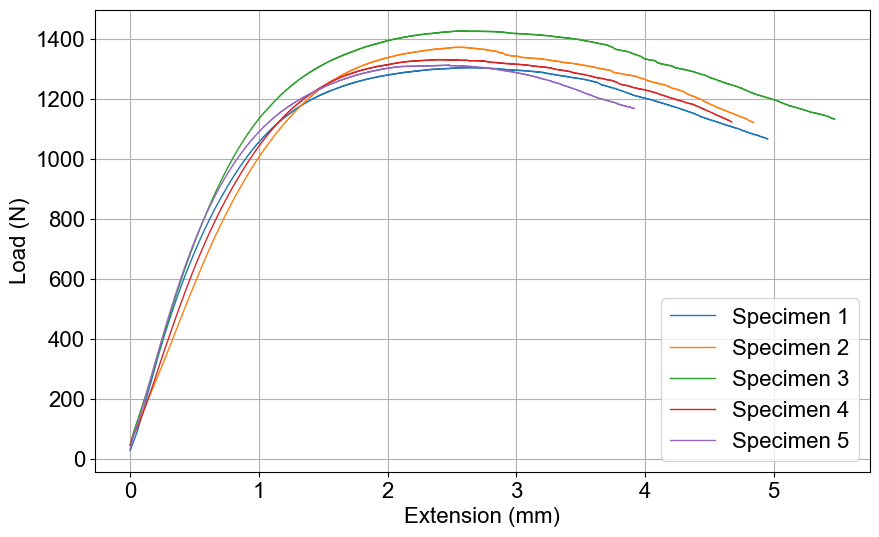

[28.7, 40.0, 27.9, 46.7, 37.7]

In [25]:
specimen_count = 5
process_specimens(
    corrected=True,
    flexion=False,
    compression=False,
    shear=True,
    specimen_count=5,
    file_path_template='short_beam/3_axis/Specimen_RawData_{}.csv',
    c1=1,
    c2=2,
    data_rows_end = {1: 5500, 2: 5500, 3: 5500, 4: 5500, 5: 5500},
    data_row_start = {1: 1, 2: 1, 3: 1, 4: 1, 5: 1},
    data_linear_start = {1: 1, 2: 1, 3: 1, 4: 1, 5: 1},
    data_linear_end = {1: 5500, 2: 5500, 3: 5500, 4: 5500, 5: 5500},
    # Area of the specimen in a dictionary
    b = {
        1: 17.18,  # b_1_A
        2: 16.64,  # b_2_A
        3: 17.3,   # b_3_A
        4: 17.6,   # b_4_A
        5: 15.69,  # b_1_B
    },

    h = {
        1: 3.43,  # h_1_A
        2: 3.21,  # h_2_A
        3: 3.41,  # h_3_A
        4: 3.00,  # h_4_A
        5: 3.55,  # h_1_B
    },
    L=30,
    specimen_number=range(1, specimen_count + 1),
)

#range(1, specimen_count + 1)
# print(range(1, specimen_count + 1))

# 5 axis

Mean Interl: 20.14377154019202
Standard Deviation Interl: 5.702135230499137
Coeff Variance Interl: 28.307187753405103
Uncertainty Interl: 3.432163372529028


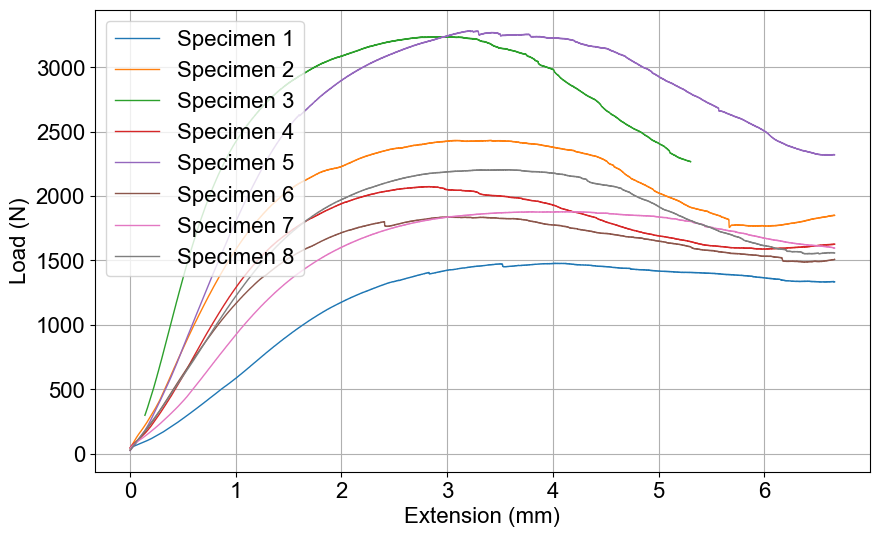

In [ ]:
specimen_count = 8
S = process_specimens(
    corrected=False,
    flexion=False,
    compression=False,
    shear=True,
    specimen_count=8,
    file_path_template='short_beam/5_axis/Specimen_RawData_{}.csv',
    c1=1,
    c2=2,
    data_row_start={1: 2, 2: 2, 3: 85, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2},
    data_rows_end={1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000, 6: 4000, 7: 4000, 8: 4000},
    data_linear_start={1: 110, 2: 110, 3: 110, 4: 110, 5: 110, 6: 110, 7: 110, 8: 110},
    data_linear_end={1: 360, 2: 360, 3: 360, 4: 360, 5: 360, 6: 360, 7: 360, 8: 360},
    b={1: 10.90, 2: 10.30, 3: 10.60, 4: 11.50, 5: 11.10, 6: 10.30, 7: 10.70, 8: 9.80},
    h={1: 9.00, 2: 7.70, 3: 7.80, 4: 7.80, 5: 8.10, 6: 7.75, 7: 8.40, 8: 8.50},
    L=28,
    specimen_number=range(1, specimen_count + 1),
)
#range(1, specimen_count + 1)
# print(range(1, specimen_count + 1))

In [41]:
stderr_list = S[:]
best_specimens = select_best_specimens(stderr_list)
print(f"Best specimens (indices): {best_specimens}")

Best specimens (indices): [1, 6, 8, 3, 4, 7]


Mean Interl: 18.622292089412106
Standard Deviation Interl: 2.5636996225630355
Coeff Variance Interl: 13.766831764069757
Uncertainty Interl: 3.2115787249291166


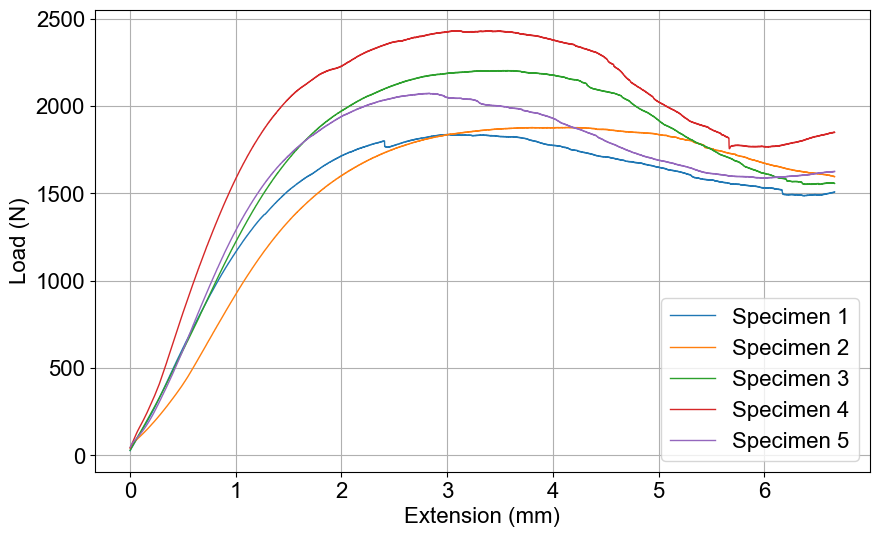

[0.1, 0.2, 0.1, 0.3, 0.2]

In [ ]:
data_row_start={1: 2, 2: 2, 3: 85, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2}
data_rows_end={1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000, 6: 4000, 7: 4000, 8: 4000}
data_linear_start={1: 110, 2: 110, 3: 110, 4: 110, 5: 110, 6: 110, 7: 110, 8: 110}
data_linear_end={1: 360, 2: 360, 3: 360, 4: 360, 5: 360, 6: 360, 7: 360, 8: 360}
b={1: 10.90, 2: 10.30, 3: 10.60, 4: 11.50, 5: 11.10, 6: 10.30, 7: 10.70, 8: 9.80}
h={1: 9.00, 2: 7.70, 3: 7.80, 4: 7.80, 5: 8.10, 6: 7.75, 7: 8.40, 8: 8.50}
L=28
specimen_count = 5
specimens = [6, 1, 8, 3, 4]

process_specimens(
    corrected=False,
    flexion=False,
    compression=False,
    shear=True,
    specimen_count=5,
    file_path_template='short_beam/5_axis/Specimen_RawData_{}.csv',
    c1=1,
    c2=2,
    data_row_start={1: 2, 2: 2, 3: 85, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2},
    data_rows_end={1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000, 6: 4000, 7: 4000, 8: 4000},
    data_linear_start={1: 110, 2: 110, 3: 110, 4: 110, 5: 110, 6: 110, 7: 110, 8: 110},
    data_linear_end={1: 360, 2: 360, 3: 360, 4: 360, 5: 360, 6: 360, 7: 360, 8: 360},
    b={1: 10.90, 2: 10.30, 3: 10.60, 4: 11.50, 5: 11.10, 6: 10.30, 7: 10.70, 8: 9.80},
    h={1: 9.00, 2: 7.70, 3: 7.80, 4: 7.80, 5: 8.10, 6: 7.75, 7: 8.40, 8: 8.50},
    L=28,
    specimen_number = [6, 7, 8, 2, 4],
    DIC_short=False
)

#range(1, specimen_count + 1)
# print(range(1, specimen_count + 1))

# DIC

Mean of error GPa Interlaminar: 20.92
Mean of flexural modulus MPa: 613.8199999999999
Standard deviation of slope MPa: 507.2424643107081
Coefficient of variation of slope: 82.63700503579358%


[26.5, 11.1, 21.6, 31.0, 14.4]

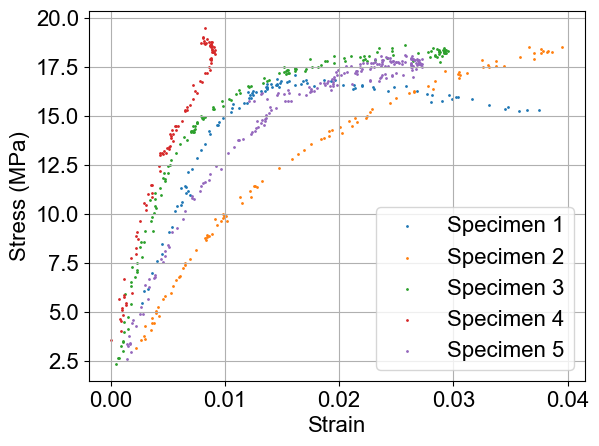

In [79]:
specimen_count = 5
process_specimens(
    corrected=False,
    flexion=False,
    compression=False,
    shear=False,
    specimen_count=5,
    file_path_template='short_beam/3_axis/{}_exp_2.csv',
    c1=3,
    c2=8,
    data_rows_end = {1: 100, 2: 100, 3: 150, 4: 100, 5: 200},
    data_row_start = {1: 1, 2: 1, 3: 1, 4: 1, 5: 1},
    data_linear_start = {1: 1, 2: 1, 3: 1, 4: 1, 5: 1},
    data_linear_end = {1: 100, 2: 100, 3: 150, 4: 100, 5: 200},
    # Area of the specimen in a dictionary
    b = {
        1: 17.18,  # b_1_A
        2: 16.64,  # b_2_A
        3: 17.3,   # b_3_A
        4: 17.6,   # b_4_A
        5: 15.69,  # b_1_B
    },

    h = {
        1: 3.43,  # h_1_A
        2: 3.21,  # h_2_A
        3: 3.41,  # h_3_A
        4: 3.00,  # h_4_A
        5: 3.55,  # h_1_B
    },
    L=30,
    specimen_number=range(1, specimen_count + 1),
    DIC_short=True
)

#range(1, specimen_count + 1)
# print(range(1, specimen_count + 1))